In [1]:
import pandas as pd
import math
import numpy as np
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

In [2]:
def y_transform_fn(value):
    if value < 1800:
        scaled_value = value/3600
    elif value >= 1800 and value <= 7200:
        scaled_value = (value + 3600)/10800
    else:
        scaled_value = value/7200
    return math.log(1+1/scaled_value)


def remove_one_hot(X):
    mappings = {
        'tone': ['tone_1', 'tone_2', 'tone_3'],
        'day_of_week': ['day_of_week_0', 'day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4','day_of_week_5','day_of_week_6']
    }
    X_transformed = X[:]
    
    def clean_col_name(element):
        return int(element[-1])
            
    for (col, cols) in mappings.items():
        X_transformed[col] = list(map(clean_col_name, (X.loc[:, cols] == 1).idxmax(1)))
        X_transformed = X_transformed.drop(cols, axis=1)
    
    return X_transformed

In [3]:
X_pd = pd.read_pickle('training_data_X')
y_pd = pd.read_pickle('training_data_y')
X_pd['sent_to_open_delta'] = X_pd['sent_to_open_delta'].apply(y_transform_fn)
X_pd_no_onehot = remove_one_hot(X_pd)
X = X_pd.values
y_original = y_pd.values

N = len(y_original)
y = np.reshape(list(map(y_transform_fn, y_original)), (N, 1))
M = len(list(X_pd.columns.values))

/Users/julien/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
def scale(X, normalisation=None):
    columns_to_scale = ['last_report_delta', 'package_duration', 'end_to_sent_delta', 'sent_to_open_delta', 'time_of_day']
    columns_indexes = [X_pd.columns.get_loc(col) for col in columns_to_scale]
    X_transformed = X[:]
    if len(X.shape) == 2 and X.shape[1] > 1:
        if normalisation == None:
            normalisation = StandardScaler().fit(X[:, columns_indexes])
        X_transformed[:, columns_indexes] = normalisation.transform(X[:, columns_indexes])
    else:
        if normalisation == None:
            normalisation = StandardScaler().fit(X)
        X_transformed = normalisation.transform(X)
    
    return X_transformed, normalisation

Should we normalise sent_to_open_delta? What about the output column? I'm wondering...

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
def SVD(X, pandas=X_pd_no_onehot):
    M = X.shape[1]
    X_stand, _ = scale(X)
    if (M > 1):
        U, S, V = linalg.svd(X_stand, full_matrices=True)
        rho = (S*S) / (S*S).sum()
        V = np.mat(V).T

        # plt.plot variance explained
        plt.figure(figsize=(10, 5))
        plt.xticks(range(1,len(rho)+1))
        plt.plot(range(1,len(rho)+1), rho, 'o-')
        plt.title('Variance explained by principal components');
        plt.xlabel('Principal component');
        plt.ylabel('Variance explained');
    
    for i in range(M):
        # Compute values
        mean_x = X[:, i].mean()
        std_x = X[:, i].std(ddof=1)
        median_x = np.median(np.array(X[:, i]))
        range_x = np.array(X[:, i]).max()-np.array(X[:, i]).min()
        
        # Display results
        print('Column:',list(pandas.columns.values)[i])
        print('Mean:',mean_x)
        print('Standard Deviation:',std_x)
        print('Median:',median_x)
        print('Range:',range_x)
    
    for i in range(M):
        for j in range(M):
            if i < j:
                corr = np.corrcoef(np.array(X[:, i].flatten()), np.array(X[:, j].flatten()))[0, 1]
                if np.abs(corr) > 0.3:
                    print('Correlation between columns ',list(pandas.columns.values)[i], ' and ',list(pandas.columns.values)[j], ' : ')
                    print(corr)
            
    # Box-plotting the data to see any outliers
    plt.figure(figsize=(10,6))
    plt.title('X: Boxplot')
    plt.boxplot(X_stand)
    plt.xticks(range(1,M+1), list(pandas.columns.values), rotation=90) # No real outliers
    
    # Next, we plt.plot histograms of all attributes.
    plt.figure(figsize=(16,10))
    u = np.floor(np.sqrt(M)); v = np.ceil(float(M)/u)
    for i in range(M):
        plt.subplot(u,v,i+1)
        plt.hist(X[:,i])
        plt.title(list(pandas.columns.values)[i])
    
    plt.show()

Column: end_to_sent_delta
Mean: 7.063049063221672e-17
Standard Deviation: 1.0002486016197512
Median: -0.3086533479406572
Range: 6.275181314943213
Column: last_progress_report_value
Mean: 0.19873757476124088
Standard Deviation: 0.3320649449004282
Median: 0.0
Range: 0.99
Column: last_report_delta
Mean: 2.1189147189665015e-17
Standard Deviation: 1.0002486016197512
Median: -0.348867341935888
Range: 6.285917648970021
Column: package_duration
Mean: -3.3108042483851584e-17
Standard Deviation: 1.0002486016197512
Median: -0.5156556405439322
Range: 10.9882914771672
Column: sent_to_open_delta
Mean: -6.180167930318963e-18
Standard Deviation: 1.0002486016197512
Median: -0.20678917303166996
Range: 10.394309064800035
Column: time_of_day
Mean: -9.005387555607632e-17
Standard Deviation: 1.0002486016197512
Median: -0.047156752271218946
Range: 3.418596418707131
Column: day_of_week_0
Mean: 0.1386679920477137
Standard Deviation: 0.3456856562804921
Median: 0.0
Range: 1.0
Column: day_of_week_1
Mean: 0.140656

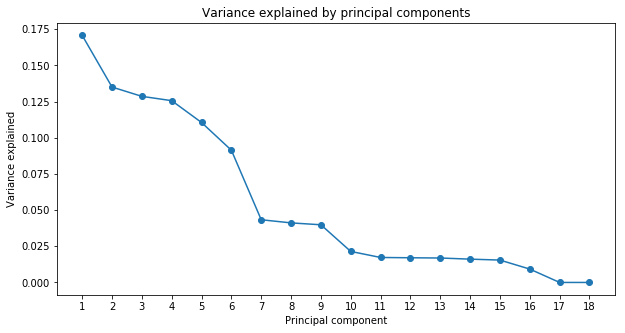

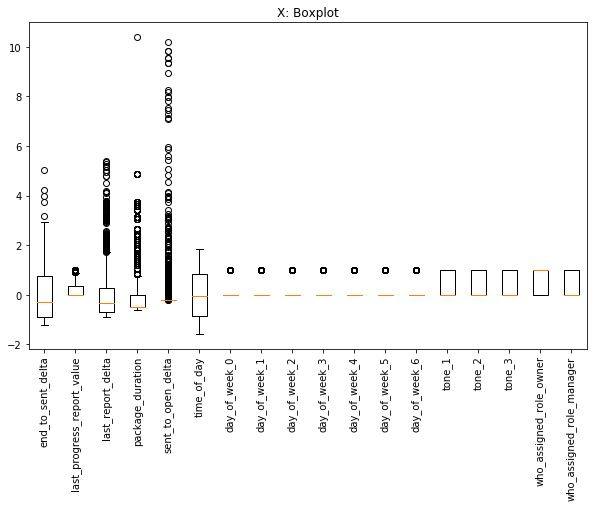

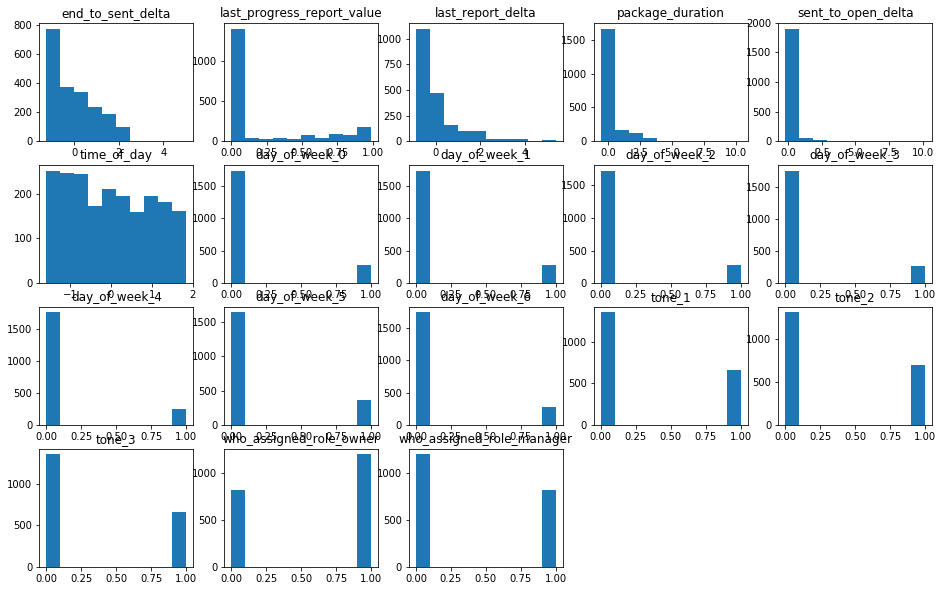

In [6]:
SVD(X, pandas=X_pd)

Column: end_to_sent_delta
Mean: 7.063049063221672e-17
Standard Deviation: 1.0002486016197512
Median: -0.3086533479406572
Range: 6.275181314943213
Column: last_progress_report_value
Mean: 0.19873757476124088
Standard Deviation: 0.3320649449004282
Median: 0.0
Range: 0.99
Column: last_report_delta
Mean: 2.1189147189665015e-17
Standard Deviation: 1.0002486016197512
Median: -0.348867341935888
Range: 6.285917648970021
Column: package_duration
Mean: -3.3108042483851584e-17
Standard Deviation: 1.0002486016197512
Median: -0.5156556405439322
Range: 10.9882914771672
Column: sent_to_open_delta
Mean: -6.180167930318963e-18
Standard Deviation: 1.0002486016197512
Median: -0.20678917303166996
Range: 10.394309064800035
Column: time_of_day
Mean: -9.005387555607632e-17
Standard Deviation: 1.0002486016197512
Median: -0.047156752271218946
Range: 3.418596418707131
Column: who_assigned_role_owner
Mean: 0.5934393638170974
Standard Deviation: 0.4913136065400085
Median: 1.0
Range: 1.0
Column: who_assigned_role_

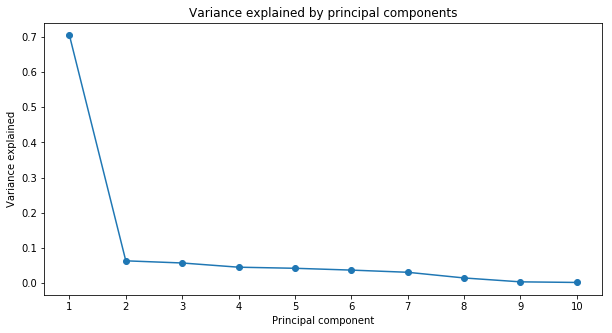

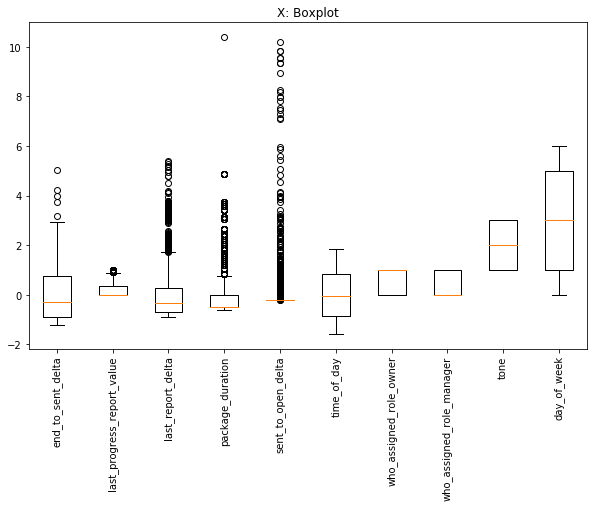

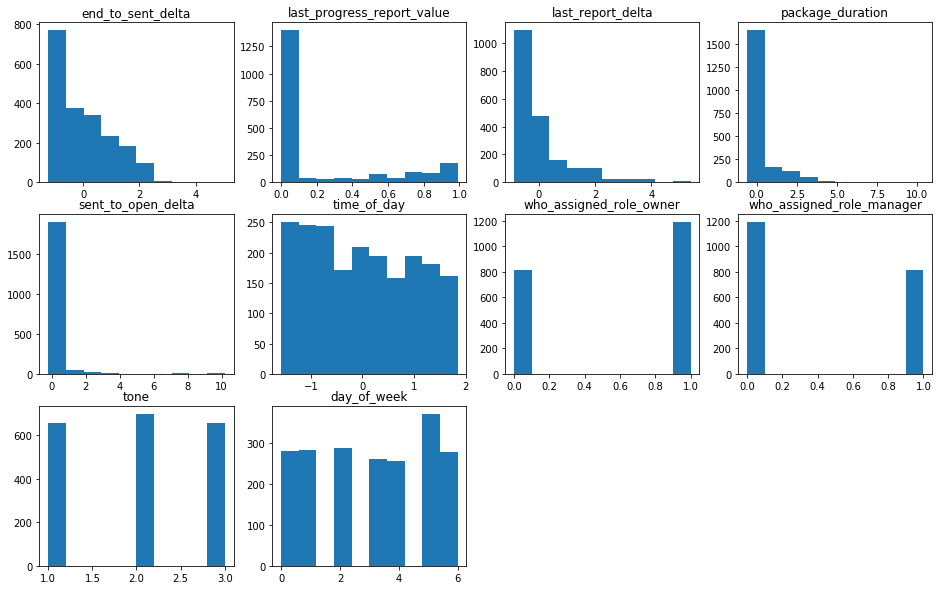

In [7]:
SVD(X_pd_no_onehot.values)

Column: end_to_sent_delta
Mean: 7.063049063221672e-17
Standard Deviation: 1.0002486016197512
Median: -0.3086533479406572
Range: 6.275181314943213
Column: last_progress_report_value
Mean: 0.19873757476124088
Standard Deviation: 0.3320649449004282
Median: 0.0
Range: 0.99
Column: last_report_delta
Mean: 2.1189147189665015e-17
Standard Deviation: 1.0002486016197512
Median: -0.348867341935888
Range: 6.285917648970021
Column: package_duration
Mean: -3.3108042483851584e-17
Standard Deviation: 1.0002486016197512
Median: -0.5156556405439322
Range: 10.9882914771672
Column: sent_to_open_delta
Mean: -6.180167930318963e-18
Standard Deviation: 1.0002486016197512
Median: -0.20678917303166996
Range: 10.394309064800035
Column: time_of_day
Mean: -9.005387555607632e-17
Standard Deviation: 1.0002486016197512
Median: -0.047156752271218946
Range: 3.418596418707131
Column: who_assigned_role_owner
Mean: 0.5934393638170974
Standard Deviation: 0.4913136065400085
Median: 1.0
Range: 1.0
Column: who_assigned_role_

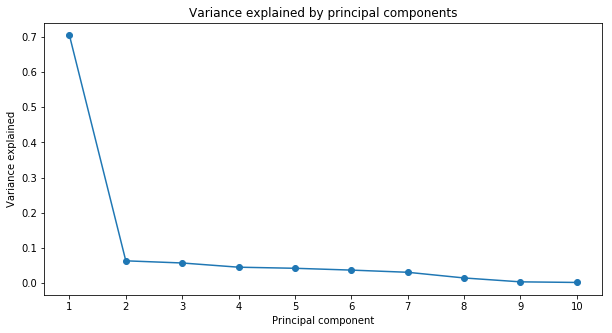

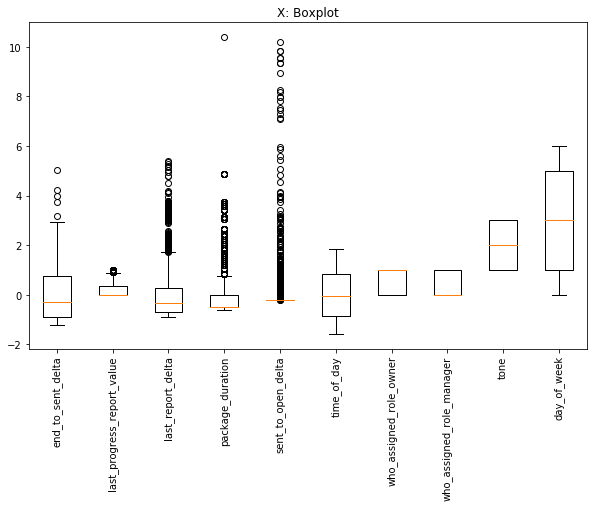

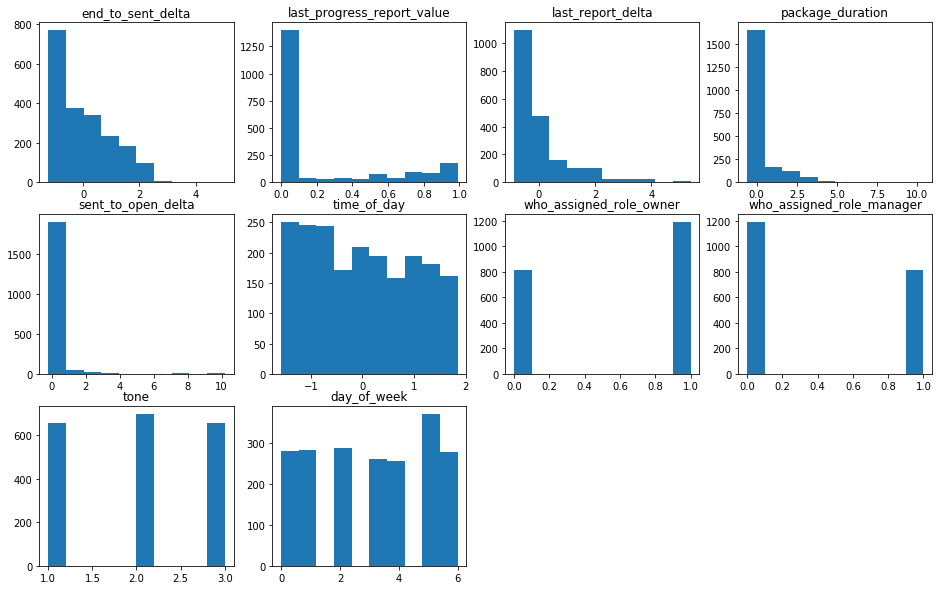

In [8]:
X_opened = X_pd_no_onehot.loc[X_pd_no_onehot['sent_to_open_delta'] != math.inf].values
SVD(X_opened)

Column: end_to_sent_delta
Mean: -4.827056628805028e-17
Standard Deviation: 1.0073261052672768
Median: -0.4642385089231167
Range: 3.664229411758474
Column: last_progress_report_value
Mean: 0.38
Standard Deviation: 0.3956416976775532
Median: 0.25
Range: 0.99
Column: last_report_delta
Mean: -1.769920763895177e-17
Standard Deviation: 1.007326105267277
Median: -0.3563691199486086
Range: 5.141687308621841
Column: package_duration
Mean: -6.436075505073371e-18
Standard Deviation: 1.007326105267277
Median: -0.47445598745792966
Range: 2.953121674512629
Column: sent_to_open_delta
Mean: 4.827056628805028e-17
Standard Deviation: 1.007326105267277
Median: -0.35451327689018985
Range: 4.682399757892831
Column: time_of_day
Mean: 5.792467954566034e-17
Standard Deviation: 1.007326105267277
Median: 0.09783712246073525
Range: 3.8693388797581005
Column: who_assigned_role_owner
Mean: 0.2898550724637681
Standard Deviation: 0.45701876893374443
Median: 0.0
Range: 1.0
Column: who_assigned_role_manager
Mean: 0.71

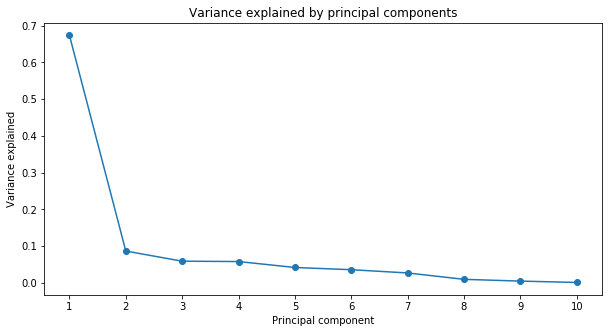

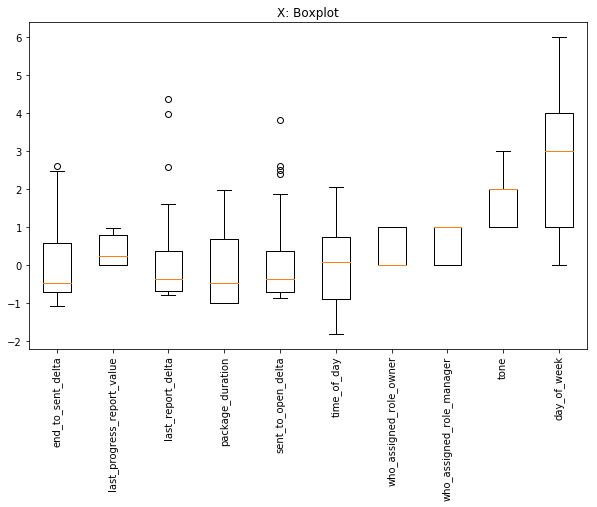

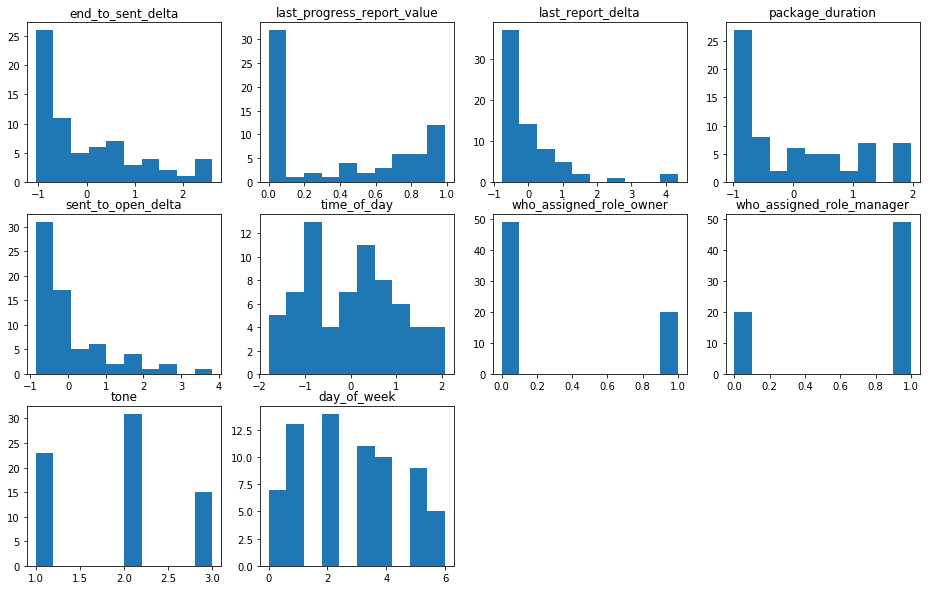

In [9]:
X_reported = X_pd_no_onehot.loc[y_pd[y_pd != math.inf].index, :].values
SVD(X_reported)

Column: end_to_sent_delta
Mean: -6.232831015439475e-17
Standard Deviation: 1.0006271559098778
Median: -0.21985111585173012
Range: 5.118026587066665
Column: last_progress_report_value
Mean: 0.20286967436472575
Standard Deviation: 0.33315217920270707
Median: 0.0
Range: 0.99
Column: last_report_delta
Mean: -8.458842092382145e-17
Standard Deviation: 1.0006271559098778
Median: -0.3296512770742936
Range: 6.662884898346215
Column: package_duration
Mean: -2.4486121846369366e-17
Standard Deviation: 1.000627155909878
Median: -0.5414231919447919
Range: 5.576036551523374
Column: sent_to_open_delta
Mean: -4.452022153885339e-17
Standard Deviation: 1.0006271559098778
Median: -0.24379100569612555
Range: 8.73822226846574
Column: time_of_day
Mean: 2.4486121846369366e-16
Standard Deviation: 1.0006271559098778
Median: -0.06658130389913766
Range: 3.3585477977026486
Column: who_assigned_role_owner
Mean: 0.5964912280701754
Standard Deviation: 0.4909087870345157
Median: 1.0
Range: 1.0
Column: who_assigned_rol

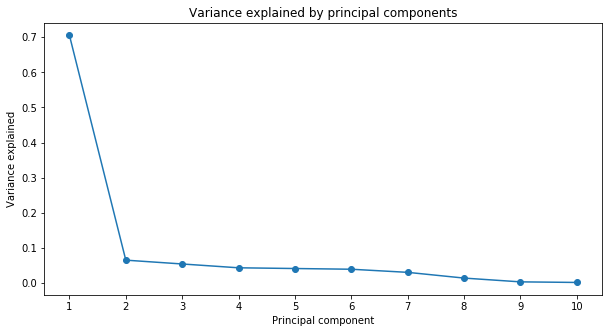

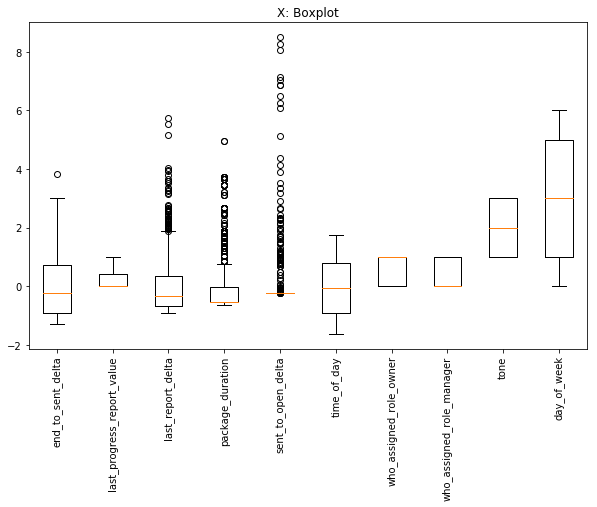

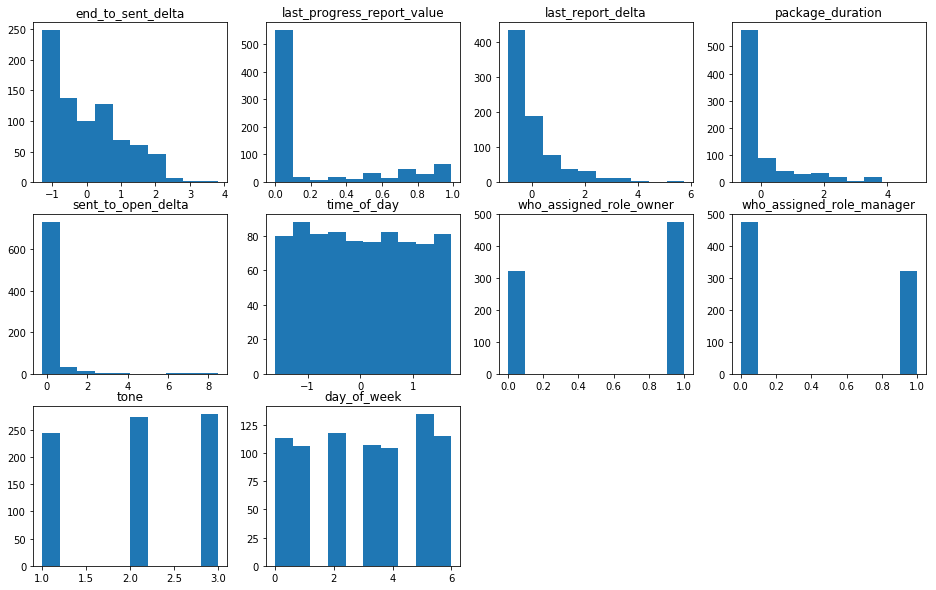

In [10]:
X_opened_day = X_pd_no_onehot.loc[(X_pd_no_onehot['sent_to_open_delta'] != math.inf) & (X_pd_no_onehot['time_of_day'] > 500) & (X_pd_no_onehot['time_of_day'] < 1100)].values
SVD(X_opened_day)

Column: end_to_sent_delta
Mean: 8.194067792950085e-17
Standard Deviation: 1.0004121162342678
Median: -0.2897161292166456
Range: 6.182496929338029
Column: last_progress_report_value
Mean: 0.19602141703176734
Standard Deviation: 0.33145770084370396
Median: 0.0
Range: 0.99
Column: last_report_delta
Mean: 5.2676150097536257e-17
Standard Deviation: 1.0004121162342678
Median: -0.35788501951988233
Range: 6.047713959436491
Column: package_duration
Mean: -4.023872576895131e-17
Standard Deviation: 1.0004121162342678
Median: -0.4995166456557642
Range: 10.83330616390619
Column: sent_to_open_delta
Mean: -1.9021943090776983e-17
Standard Deviation: 1.000412116234268
Median: -0.17914096966275372
Range: 11.75981039815161
Column: time_of_day
Mean: -1.199845641110548e-16
Standard Deviation: 1.000412116234268
Median: -0.4000527334640931
Range: 2.877374116474753
Column: who_assigned_role_owner
Mean: 0.5914332784184514
Standard Deviation: 0.49177145518506105
Median: 1.0
Range: 1.0
Column: who_assigned_role_

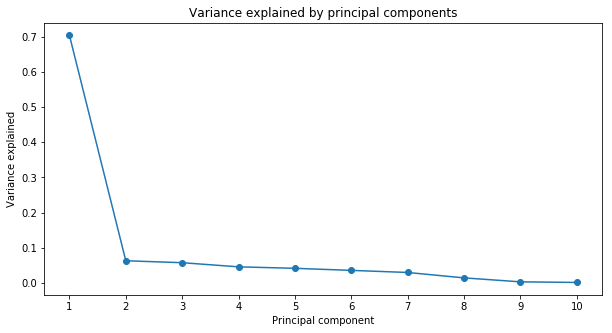

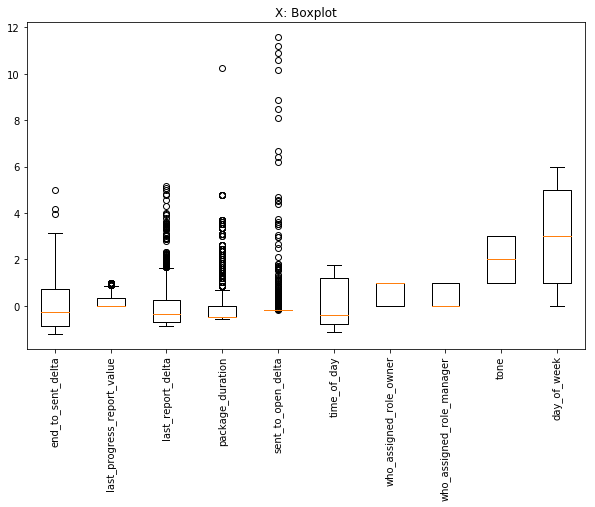

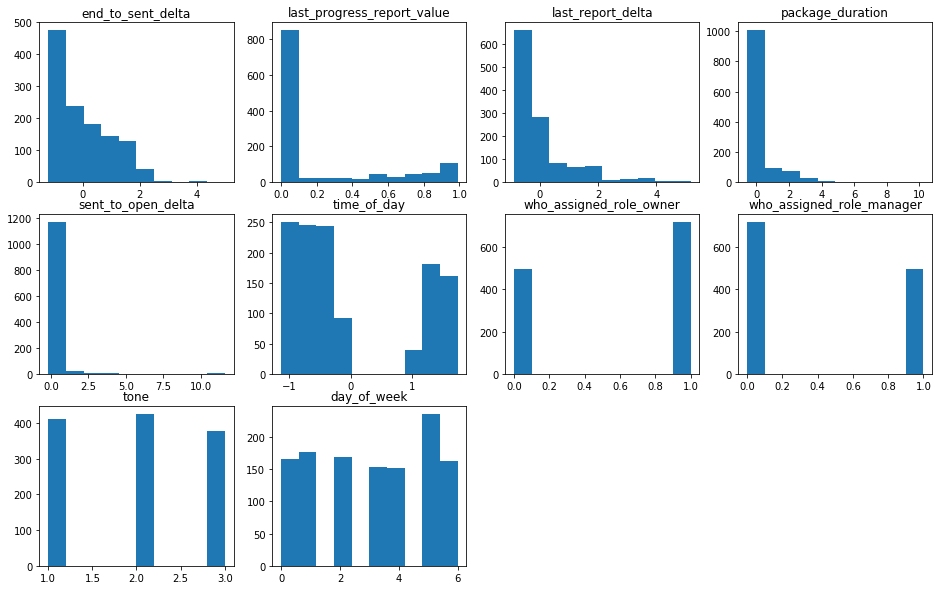

In [11]:
X_opened_night = X_pd_no_onehot.loc[(X_pd_no_onehot['sent_to_open_delta'] != math.inf) & ((X_pd_no_onehot['time_of_day'] < 500) | (X_pd_no_onehot['time_of_day'] > 1100))].values
SVD(X_opened_night)

Mean: 1.7657622658054178e-18
Standard Deviation: 1.0002486016197512
Median: -0.12077202821816303
Range: 20.470153253853706


([<matplotlib.axis.XTick at 0x11680c128>,
 <a list of 2 Text xticklabel objects>)

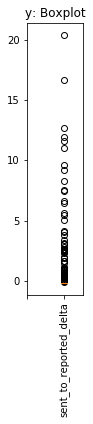

In [12]:
y, _ = scale(y)
mean_x = y.mean()
std_x = y.std(ddof=1)
median_x = np.median(np.array(y))
range_x = np.array(y).max()-np.array(y).min()

# Display results
print('Mean:',mean_x)
print('Standard Deviation:',std_x)
print('Median:',median_x)
print('Range:',range_x)


plt.figure(figsize=(1, 5))
plt.title('y: Boxplot')
plt.boxplot(y)
plt.xticks(range(2), ['', 'sent_to_reported_delta'], rotation=90)
